<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/Image_Super_Resolution_Using_Efficient_Sub_Pixel_CNN__Euro_SAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check package versions
import sys
import matplotlib
from multiprocessing import Pool

print('Python: {}'.format(sys.version))
print('Matplotlib: {}'.format(matplotlib.__version__))

Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Matplotlib: 3.2.2


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout,Activation
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session

from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math
import os
import glob
import cv2
import pandas as pd


# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip


--2021-07-04 20:17:50--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  10.1MB/s    in 11s     

2021-07-04 20:18:01 (8.24 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [ ]:
!unzip /content/EuroSAT.zip -d /content/
Land_images = glob.glob('/content/2750/**/*.jpg') #returns path of images
print(len(Land_images)) #contains 13243 images

Streaming output truncated to the last 5000 lines.
  inflating: /content/2750/SeaLake/SeaLake_1313.jpg  
  inflating: /content/2750/SeaLake/SeaLake_263.jpg  
  inflating: /content/2750/SeaLake/SeaLake_967.jpg  
  inflating: /content/2750/SeaLake/SeaLake_515.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1465.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1817.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2902.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2570.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1004.jpg  
  inflating: /content/2750/SeaLake/SeaLake_174.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2111.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2388.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1948.jpg  
  inflating: /content/2750/SeaLake/SeaLake_838.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2738.jpg  
  inflating: /content/2750/SeaLake/SeaLake_1999.jpg  
  inflating: /content/2750/SeaLake/SeaLake_2359.jpg  
  inflating: /content/2750/SeaLake/S

In [ ]:
def ssim(y_pred, y_true):
  return tf.image.ssim(y_true, y_pred , max_val=2.0)

def psnr(y_pred, y_true):
  return tf.image.psnr(y_true, y_pred , max_val=1.0)

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)


def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref))
    
    return scores

In [ ]:
'''# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [ ]:
# prepare degraded images by introducing quality distortions via resizing

from tqdm import tqdm
progress = tqdm(total= len(Land_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(64,64,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, Land_images)


 10%|▉         | 2665/27000 [00:12<00:47, 511.70it/s]

In [ ]:
def get_low_res(img , factor):
  # find old and new image dimensions
  h, w, _ = img.shape
  new_height = int(h / factor)
  new_width = int(w / factor)
          
  # resize the image - down
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
          
  # resize the image - up
  low_img_resloution = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
  return low_img_resloution


In [ ]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2 , train_size = 0.8)

In [ ]:
all_images.shape

(27000, 64, 64, 3)

In [ ]:
# get low resloution images for training
train_x_low = []

for i in range(train_x.shape[0]):
  temp = get_low_res(train_x[i,:,:,:] , 0.75)
  train_x_low.append(temp)
train_x_low = np.array(train_x_low)

val_x_low = []

for i in range(val_x.shape[0]):
  temp = get_low_res(val_x[i,:,:,:] , 0.75)
  val_x_low.append(temp)
val_x_low = np.array(val_x_low)



In [ ]:
del all_images
del img_array

NameError: ignored

In [ ]:
import gc
gc.collect()

18396

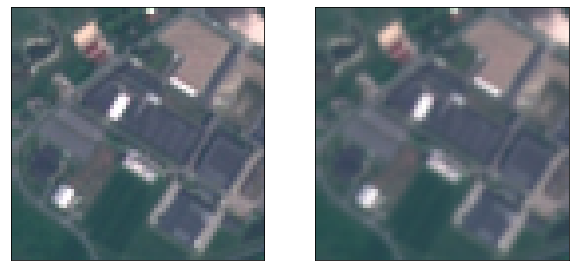

In [ ]:
n = 1
plt.figure(figsize= (10,10))
for i in range(n):
  ax = plt.subplot(1, 2, i+1)
  plt.imshow(train_x[i+10])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(1, 2, i+1+n)
  plt.imshow(train_x_low[i+10])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# test the generated images using the image quality metrics

for i in range(val_x.shape[0]):
    
    # open target and reference images
    target = val_x_low[i,:,:,:]
    ref = val_x[i,:,:,:]
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(i, scores[0], scores[1], scores[2]))
    

Streaming output truncated to the last 5000 lines.
4400
PSNR: 36.490238189697266
MSE: 0.0006731270674544666
SSIM: 0.9796941876411438

4401
PSNR: 35.926361083984375
MSE: 0.0007664522286506895
SSIM: 0.9836791157722473

4402
PSNR: 53.420806884765625
MSE: 1.3647092546623332e-05
SSIM: 0.9989519715309143

4403
PSNR: 41.30260467529297
MSE: 0.00022225963030541446
SSIM: 0.9928083419799805

4404
PSNR: 42.99390411376953
MSE: 0.00015056730673900371
SSIM: 0.9906670451164246

4405
PSNR: 55.973785400390625
MSE: 7.581277209187118e-06
SSIM: 0.9992783665657043

4406
PSNR: 46.71318817138672
MSE: 6.394440361032899e-05
SSIM: 0.9967154860496521

4407
PSNR: 35.14581298828125
MSE: 0.0009173601080300563
SSIM: 0.9705504775047302

4408
PSNR: 45.25969696044922
MSE: 8.936172376883392e-05
SSIM: 0.9940821528434753

4409
PSNR: 48.64116287231445
MSE: 4.102087276678893e-05
SSIM: 0.9971426129341125

4410
PSNR: 44.97235107421875
MSE: 9.54741812514281e-05
SSIM: 0.9958636164665222

4411
PSNR: 48.259063720703125
MSE: 4.4793

In [ ]:
clear_session()

Input_img = Input(shape=(64, 64, 3))
'''C1 = Conv2D(64,(9,9),padding='SAME',name='CONV1')(Input_img)
A1 = Activation('relu', name='act1')(C1)
C2 = Conv2D(32,(1,1),padding='SAME',name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)
C3 = Conv2D(1,(5,5),padding='SAME',name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)'''

l1 = Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(Input_img)
l2 = Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l1)
l3 = Conv2D(filters=32, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l2)
l4 = Conv2D(filters=27, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l3)
result = Conv2D(filters=3, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='linear', padding='same', use_bias=True)(l4)
adam = Adam(lr=0.001)

ESPCN = Model(Input_img, result )

# compile model
ESPCN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

   



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
ESPCN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 27)        7803      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 3)         732       
Total params: 68,791
Trainable params: 68,791
Non-trainable params: 0
_________________________________________________________

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)
#model = get_model(factor=factor, channels=3)
'''model.summary()

callbacks = [ESPCNCallback(), early_stopper, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)'''




'model.summary()\n\ncallbacks = [ESPCNCallback(), early_stopper, model_checkpoint_callback]\nloss_fn = keras.losses.MeanSquaredError()\noptimizer = keras.optimizers.Adam(learning_rate=0.001)'

In [ ]:
history = ESPCN.fit(train_x_low,train_x,
            epochs=15,
            validation_data=(val_x_low, val_x),
            callbacks=[early_stopper, model_checkpoint])


Epoch 1/15
675/675 [==============================] - 46s 21ms/step - loss: 9.5220e-04 - mean_squared_error: 9.5220e-04 - val_loss: 9.9896e-05 - val_mean_squared_error: 9.9896e-05
Epoch 2/15
675/675 [==============================] - 14s 21ms/step - loss: 1.2370e-04 - mean_squared_error: 1.2370e-04 - val_loss: 9.8981e-05 - val_mean_squared_error: 9.8981e-05
Epoch 3/15
675/675 [==============================] - 15s 22ms/step - loss: 1.1085e-04 - mean_squared_error: 1.1085e-04 - val_loss: 1.5372e-04 - val_mean_squared_error: 1.5372e-04
Epoch 4/15
675/675 [==============================] - 15s 22ms/step - loss: 7.8062e-05 - mean_squared_error: 7.8062e-05 - val_loss: 4.6886e-05 - val_mean_squared_error: 4.6886e-05
Epoch 5/15
675/675 [==============================] - 14s 21ms/step - loss: 1.2500e-04 - mean_squared_error: 1.2500e-04 - val_loss: 4.3521e-05 - val_mean_squared_error: 4.3521e-05
Epoch 6/15
675/675 [==============================] - 14s 21ms/step - loss: 1.0420e-04 - mean_square

In [ ]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
    

In [ ]:
val_x_low.shape


(5400, 64, 64, 3)

In [ ]:
# define main prediction function

    
# load the ESsrcnn model with weights
ESPCN.load_weights('/content/superResolution_checkpoint3.h5')
    
predictions = ESPCN.predict(val_x_low)

In [ ]:
def predict(image_index):
  # image quality calculations
  ref = val_x[image_index]
  degraded = val_x_low[image_index]
  output = predictions[image_index]
  scores = []
  scores.append(compare_images(val_x_low[i], val_x[i]))
  scores.append(compare_images(predictions[i], val_x[i]))
    
  # return images and scores
  return ref, degraded, output, scores
  

Degraded Image: 
PSNR: 35.96070861816406
MSE: 0.0007604141834971405
SSIM: 0.9846728444099426

Reconstructed Image: 
PSNR: 41.87147521972656
MSE: 0.00019497256846097964
SSIM: 0.9960682988166809



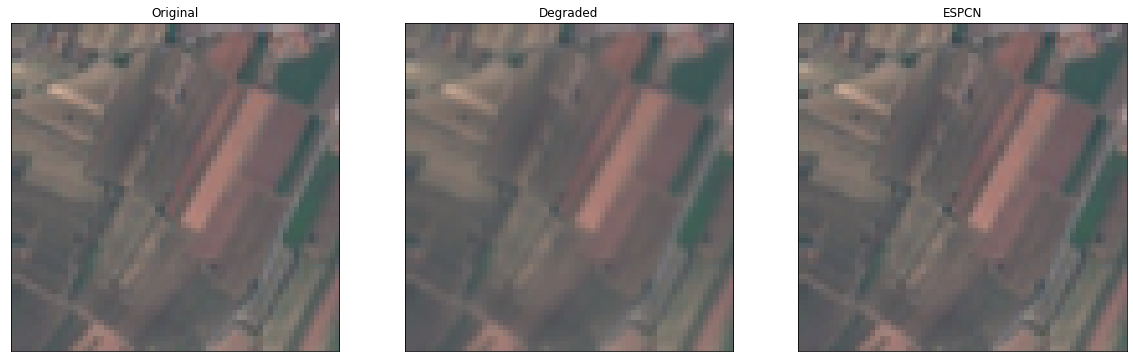

In [ ]:
ref, degraded, output, scores = predict(302)

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(ref)
axs[0].set_title('Original')
axs[1].imshow(degraded)
axs[1].set_title('Degraded')
axs[2].imshow(output)
axs[2].set_title('ESPCN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
ssim = list(map(SSIM,predictions,x_test_images))
mse = list(map(mse, predictions, x_test_images))
Psnr = list(map(Psnr , predictions , x_test_images))